# Baseline model for batch monitoring example

In [27]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric

from evidently.metrics import ColumnQuantileMetric, ColumnMissingValuesMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [28]:
# files = [('green_tripdata_2022-02.parquet', './data'), ('green_tripdata_2022-01.parquet', './data')]

# print("Download files:")
# for file, path in files:
#     url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
#     resp=requests.get(url, stream=True)
#     save_path=f"{path}/{file}"
#     with open(save_path, "wb") as handle:
#         for data in tqdm(resp.iter_content(),
#                         desc=f"{file}",
#                         postfix=f"save to {save_path}",
#                         total=int(resp.headers["Content-Length"])):
#             handle.write(data)

In [29]:
jan_data = pd.read_parquet('/root/mlops-zoom-camp/monitoring/data/green_tripdata_2024-03.parquet')

In [30]:
jan_data.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,57457.000000,57457,57457,55360.000000,57457.000000,57457.000000,55360.000000,57457.000000,57457.000000,57457.000000,57457.000000,57457.000000,57457.000000,0.0,57457.000000,57457.000000,55360.000000,55353.000000,55360.000000
mean,1.877334,2024-03-16 04:02:52.405398528,2024-03-16 04:21:00.076039424,1.179986,95.524688,138.629149,1.309538,13.522828,17.313474,0.904472,0.577410,2.386255,0.192537,NaN,0.979378,22.904832,1.321062,1.038047,0.737730
min,1.000000,2008-12-31 23:02:24,2008-12-31 23:02:30,1.000000,1.000000,1.000000,0.000000,0.000000,-295.080000,-2.500000,-0.500000,-1.560000,0.000000,NaN,-1.000000,-296.080000,1.000000,1.000000,-2.750000
25%,2.000000,2024-03-08 13:53:56,2024-03-08 14:13:49,1.000000,74.000000,74.000000,1.000000,1.100000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,13.440000,1.000000,1.000000,0.000000
50%,2.000000,2024-03-15 22:49:01,2024-03-15 23:09:52,1.000000,75.000000,138.000000,1.000000,1.790000,13.500000,0.000000,0.500000,2.000000,0.000000,NaN,1.000000,18.500000,1.000000,1.000000,0.000000
75%,2.000000,2024-03-23 20:11:25,2024-03-23 20:34:48,1.000000,97.000000,220.000000,1.000000,3.100000,19.800000,1.000000,0.500000,3.610000,0.000000,NaN,1.000000,27.050000,2.000000,1.000000,2.750000
max,2.000000,2024-04-01 00:01:45,2024-04-01 16:11:00,99.000000,265.000000,265.000000,9.000000,125112.200000,841.600000,10.000000,4.250000,150.000000,26.760000,NaN,1.000000,856.980000,5.000000,2.000000,2.750000
std,0.328056,NaN,NaN,1.356719,57.285088,76.295346,0.967749,770.416255,14.958249,1.382446,0.366916,3.159273,1.184551,NaN,0.154253,17.013735,0.497858,0.191311,1.218039


In [31]:
jan_data.shape

(57457, 20)

In [32]:
# create target
jan_data["duration_min"] = jan_data.lpep_dropoff_datetime - jan_data.lpep_pickup_datetime
jan_data.duration_min = jan_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [33]:
# filter out outliers
jan_data = jan_data[(jan_data.duration_min >= 0) & (jan_data.duration_min <= 60)]
jan_data = jan_data[(jan_data.passenger_count > 0) & (jan_data.passenger_count <= 8)]

<Axes: >

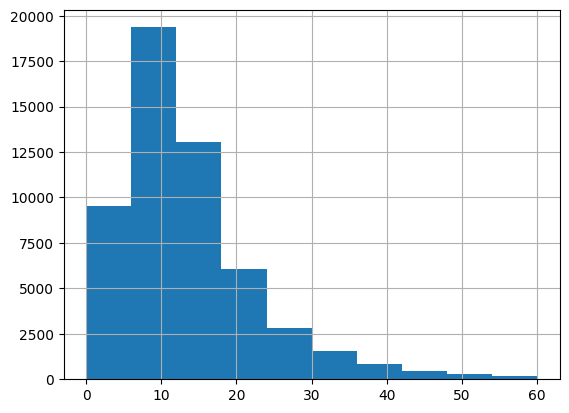

In [34]:
jan_data.duration_min.hist()

In [35]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [36]:
jan_data.shape

(54135, 21)

In [37]:
train_data = jan_data[:30000]
val_data = jan_data[30000:]

In [38]:
current_data = val_data.copy()


ref_data = train_data.copy()

In [39]:
model = LinearRegression()

In [40]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [41]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [42]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [43]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.772473239359444
3.716814567929365


# Dump model and reference data

In [44]:
import os 
os.makedirs("models",exist_ok=True)
with open('models/lin_reg_2024.bin', 'wb') as f_out:
    dump(model, f_out)

In [45]:

val_data.to_parquet('../data/reference_2024.parquet')

# Evidently Report

In [46]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [47]:
report = Report(metrics=[
    ColumnQuantileMetric(column_name="fare_amount", quantile=0.5),
    ColumnMissingValuesMetric(column_name="fare_amount")  # ✅ My chosen metric
])


In [52]:
import pandas as pd
from datetime import datetime, timedelta
from evidently.report import Report
from evidently.metrics import ColumnQuantileMetric

# === Input: Load your data ===
# You already have:
# - current_data as val_data (March 2024 batch)
# - ref_data as train_data (reference data)
current_data = val_data.copy()

print(current_data.columns)

ref_data = train_data.copy()

# === Convert pickup datetime to datetime format ===
current_data['lpep_pickup_datetime'] = pd.to_datetime(current_data['lpep_pickup_datetime'])

# === Generate all days in March 2024 ===
start_date = datetime(2024, 3, 1)
end_date = datetime(2024, 3, 31)
march_2024_dates = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]

# === Prepare list to store daily medians ===
daily_medians = []

# === Loop through each day in March ===
for date in march_2024_dates:
    # Filter current_data for just this day
    day_data = current_data[
        (current_data['lpep_pickup_datetime'] >= date) &
        (current_data['lpep_pickup_datetime'] < date + timedelta(days=1))
    ]

    # Skip empty days
    if day_data.empty:
        continue

    print(f"Date: {date.date()}, Records: {len(day_data)}, Manual median: {day_data['fare_amount'].median():.2f}")

    # Run Evidently report for quantile=0.5 (median)
    report = Report(metrics=[
        ColumnQuantileMetric(column_name="fare_amount", quantile=0.5)
    ])

    report.run(reference_data=ref_data, current_data=day_data)
    result = report.as_dict()

    # Extract the median from the result
    median = result["metrics"][0]["result"]["current"]["value"]
    daily_medians.append((date.date(), median))

    

# # === Round and find max median ===
# if daily_medians:
#     rounded_daily_medians = [(d, round(m, 1)) for d, m in daily_medians]
#     max_day, max_median = max(rounded_daily_medians, key=lambda x: x[1])
#     print(f"✅ Max daily median fare_amount was {max_median} on {max_day}")
# else:
#     print("❌ No data available for March 2024.")
    

# === Find the day with the max median ===
if daily_medians:
    max_day, max_median = max(daily_medians, key=lambda x: x[1])
    print(f"✅ Max daily median fare_amount was {max_median} on {max_day}")
else:
    print("❌ No data available for March 2024.")


Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'duration_min', 'prediction'],
      dtype='object')
Date: 2024-03-11, Records: 1, Manual median: 10.00
Date: 2024-03-12, Records: 3, Manual median: 10.70
Date: 2024-03-13, Records: 1, Manual median: 20.00
Date: 2024-03-14, Records: 1, Manual median: 14.20
Date: 2024-03-17, Records: 24, Manual median: 11.70
Date: 2024-03-18, Records: 1775, Manual median: 12.80
Date: 2024-03-19, Records: 1859, Manual median: 13.50
Date: 2024-03-20, Records: 1938, Manual median: 12.80
Date: 2024-03-21, Records: 2010, Manual median: 13.50
Date: 2024-03-22, Records: 1830, Manual median: 12.80
Date: 2024-03-23, Records: 1289, Manual me

In [ ]:
report.run(reference_data=train_data, current_data=val_data, column_mapping=column_mapping)

In [ ]:
report.show(mode='inline')

In [ ]:

## convert to dict or json formate to work with key and values in addition to filter for which key and value we need for logging
result = report.as_dict()

In [ ]:
result

In [ ]:
results = []
val_data
for date in jan_data:  # one date per dayval_data
    day_data = val_data[val_data['pickup_date'] == date]
    report = Report(metrics=[
        ColumnQuantileMetric(column_name="fare_amount", quantile=0.5)
    ])
    report.run(reference_data=ref_data, val_data=day_data)
    metric_result = report.as_dict()
    
    # Extract the daily median
    median_fare = metric_result['metrics'][0]['result']['value']
    results.append((date, median_fare))

max_median = max([value for date, value in results])
print(max_median)


In [ ]:
#prediction drift
result['metrics'][0]['result']['drift_score']

In [ ]:
#number of drifted columns
result['metrics'][1]['result']['number_of_drifted_columns']

In [ ]:
#share of missing values
result['metrics'][2]['result']['current']['share_of_missing_values']

# Evidently Dashboard

In [ ]:
from evidently.metric_preset import DataDriftPreset, DataQualityPreset

from evidently.ui.workspace import Workspace
from evidently.ui.dashboards import DashboardPanelCounter, DashboardPanelPlot, CounterAgg, PanelValue, PlotType, ReportFilter
from evidently.renderers.html_widgets import WidgetSize

In [ ]:
ws = Workspace("/root/mlops-zoom-camp/monitoring/my_workspace")

In [ ]:
project = ws.create_project("NYC Taxi Data Quality Project")
project.description = "My project descriotion"
project.save()

In [ ]:
regular_report = Report(
    metrics=[
        DataQualityPreset()
    ],
    timestamp=datetime.datetime(2023,4,28)
)

regular_report.run(reference_data=None,
                  current_data=val_data.loc[val_data.tpep_pickup_datetime.between('2023-04-28', '2023-04-29', inclusive="left")],
                  column_mapping=column_mapping)

regular_report

In [ ]:
ws.add_report(project.id, regular_report)

In [ ]:
#configure the dashboard
project.dashboard.add_panel(
    DashboardPanelCounter(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        agg=CounterAgg.NONE,
        title="NYC taxi data dashboard"
    )
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Inference Count",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_rows",
                legend="count"
            ),
        ],
        plot_type=PlotType.BAR,
        size=WidgetSize.HALF,
    ),
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Number of Missing Values",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_missing_values",
                legend="count"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Number of Missing Values2",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_missing_values",
                legend="count"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.save()

In [ ]:
regular_report = Report(
    metrics=[
        DataQualityPreset()
    ],
    timestamp=datetime.datetime(2023,4,29)
)

regular_report.run(reference_data=None,
                  current_data=val_data.loc[val_data.tpep_pickup_datetime.between('2023-04-29', '2023-04-30', inclusive="left")],
                  column_mapping=column_mapping)

regular_report

In [ ]:
ws.add_report(project.id, regular_report)